In [1]:
from fastai.vision.all import *
from moving_mnist.models.phy_original import *
from moving_mnist.models.seq2seq import TeacherForcing
from moving_mnist.models.conv_rnn import StackUnstack, StackLoss, MultiImageDice
from moving_mnist.data import *
from heat.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(3)
    print(torch.cuda.get_device_name())
    device = 0

GeForce RTX 2080 Ti


# Train PhyDNet:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
DATA_PATH = "/data/wangshuo/data/heat_diffusion/heat_diffusion_batch_1000_size_64x64_objs_2.npy"

In [4]:
ds = Heat(DATA_PATH)

In [5]:
train_tl = TfmdLists(range(900), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds))

In [6]:
# i=0
# fat_tensor = torch.stack([torch.cat(train_tl[i][0], 0) for i in range(100)])

# m,s = fat_tensor.mean(), fat_tensor.std()

In [7]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=32,#).cuda()
                             after_batch=[Normalize.from_stats(*mnist_stats)]).cuda()

In [8]:
mse_loss = StackLoss(MSELossFlat(axis=1))
metrics = []

Left: Input, Right: Target

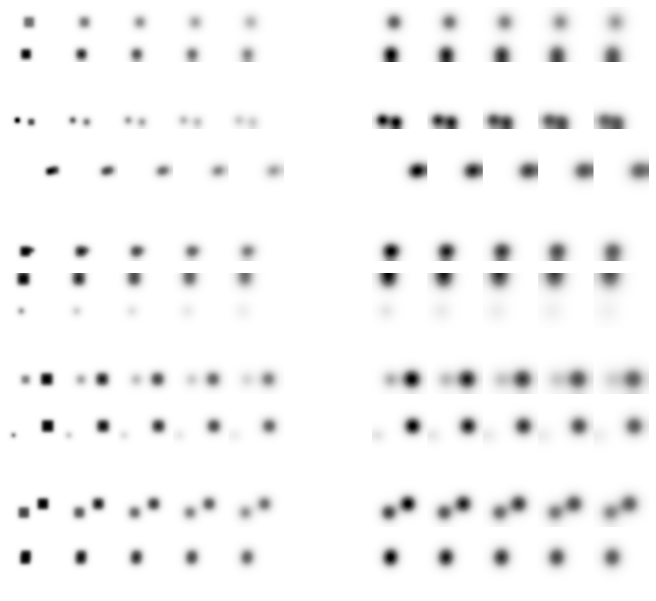

In [9]:
dls.show_batch()

In [10]:
b = dls.one_batch()

In [11]:
explode_types(b)

{tuple: [{heat.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]},
  {heat.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]}]}

## PhyDNet

In [12]:
phycell =  PhyCell(input_shape=(16,16), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7)) 
convlstm = ConvLSTM(input_shape=(16,16), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3))   
encoder =  EncoderRNN(phycell, convlstm)

layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64


In [13]:
model = StackUnstack(PhyDNet(encoder, sigmoid=False, moment=True), dim=1).cuda()

A handy callback to include the loss computed inside the model to the target loss

In [14]:
#export
class PHyCallback(Callback):
    def after_pred(self):
        self.learn.pred, self.loss_phy = self.pred
    def after_loss(self):
        self.learn.loss += self.loss_phy

In [15]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, 
                cbs=[TeacherForcing(10), PHyCallback()], opt_func=ranger)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0030199517495930195)

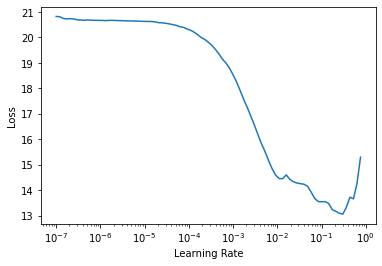

In [16]:
learn.lr_find()

In [ ]:
# learn.fit_flat_cos(25, 3e-3)
learn.fit_flat_cos(300, 3e-3)

epoch,train_loss,valid_loss,time
0,4.360585,2.479998,00:13
1,2.533366,1.771665,00:13
2,1.767954,1.351508,00:13
3,1.398217,1.006871,00:13
4,1.141488,0.855343,00:13
5,0.979774,0.756240,00:13
6,0.863541,0.698846,00:12
7,0.782607,0.666062,00:13
8,0.723542,0.637210,00:12
9,0.678673,0.607891,00:14


In [ ]:
p,t = learn.get_preds(1)

In [ ]:
len(p), p[0].shape

In [ ]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

In [ ]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k)

In [ ]:
learn.save('phydnet')